In [3]:
!pip install pymc arviz --quiet

In [3]:
!pip install numpy==1.26.4 pandas==2.2.2 scipy==1.12.0 pymc arviz --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/PimaIndiansDiabetes.csv"
data = pd.read_csv(url)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1


In [18]:
X = data.drop(columns=["Class"])
y = data["Class"]

In [19]:
X = X.iloc[:, :5]

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
with pm.Model() as probit_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    coefs = pm.Normal("coefs", mu=0, sigma=1, shape=X_train.shape[1])

    linear_combination = intercept + pm.math.dot(X_train, coefs)
    p = pm.math.sigmoid(3.5 * linear_combination)

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Output()

In [23]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],1.237,0.526,0.474,2.302,0.019,0.018,914.0,851.0,1.0
coefs[1],0.037,1.029,-1.917,2.104,0.027,0.023,1419.0,1294.0,1.0
coefs[2],0.314,0.082,0.150,0.466,0.002,0.002,1944.0,1367.0,1.0
coefs[3],0.254,0.075,0.116,0.405,0.002,0.002,1803.0,1598.0,1.0
coefs[4],0.348,0.076,0.202,0.506,0.002,0.002,1866.0,1350.0,1.0
intercept,-0.103,0.188,-0.499,0.184,0.007,0.006,916.0,841.0,1.0


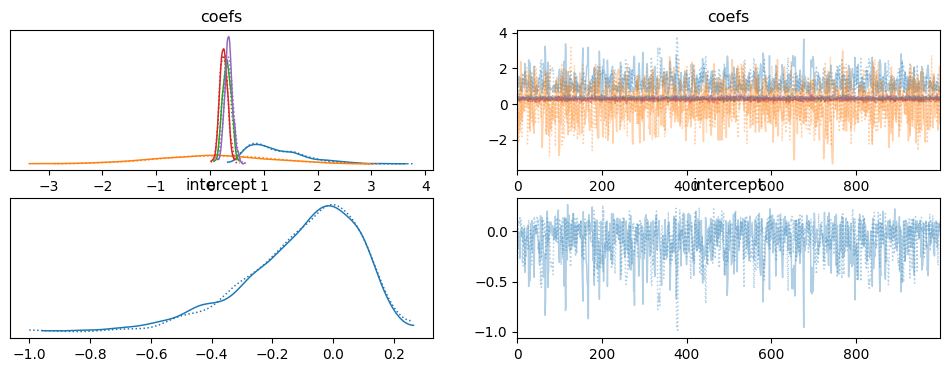

In [24]:
az.plot_trace(trace)
plt.show()

In [26]:
with probit_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

Output()

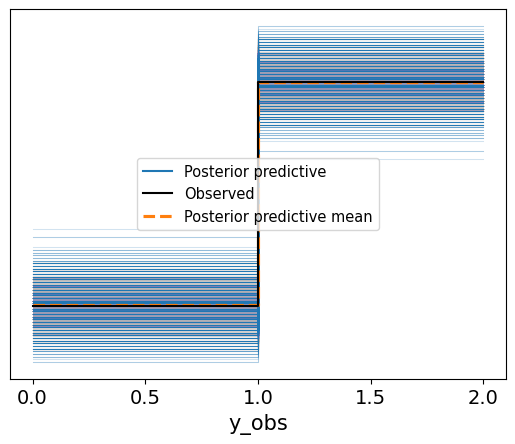

In [29]:
az.plot_ppc(posterior_predictive)
plt.show()